In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from NeuralNetwork import NeuralNetwork
import numpy as np
import sklearn
from Config import cfg
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

import pathlib

PATH = pathlib.Path("results/LR")
PATH.mkdir(exist_ok=True)


def add_polynomials(X, num_poly):
    poly = PolynomialFeatures(num_poly)
    X = poly.fit_transform(X)
    return X

def mse(pred, actual):
    return np.mean(np.square(pred - actual))

def R_squared(pred, actual):
        r_sq = 1 - mse(pred, actual)/ mse(actual.mean(), actual)
        return r_sq
    
def normalize_data(X_train, X_test, y_train, y_test, normalize_y = False):
    # Checking for constant column and removing it to keep it as ones
    condition = np.all(X_train[:,0] == 1)
    if condition:
        X_train = X_train[:,1:]
        X_test = X_test[:,1:]
    
    if normalize_y:
        
        train_data = np.concatenate((X_train, y_train.reshape(-1,1)), axis = 1)
        test_data = np.concatenate((X_test, y_test.reshape(-1,1)), axis = 1)
    
    else:
        train_data = X_train
        test_data = X_test

    # Scale data to 0 mean and 1 standard deviation
    scaler = StandardScaler(with_mean=True).fit(train_data)

    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    
    if normalize_y:
        
        y_train = train_data[:,-1]
        y_test = test_data[:,-1]

        X_train = train_data[:,:-1]
        X_test = test_data[:,:-1]
        
    else:
        X_train = train_data
        y_train = y_train
        
        X_test = test_data
        y_test = y_test

#     assert X_train.shape != train_data.shape

    # Adding back constant column if it was present
    if condition:
        X_train = np.concatenate([np.ones((len(X_train), 1)), X_train], axis = 1)
        X_test = np.concatenate([np.ones((len(X_test), 1)), X_test], axis = 1)

    return X_train, X_test, y_train, y_test


def model_eval(preds, actual):
    results = pd.DataFrame()
    results['preds'] = preds.flatten()
    results['targets'] = actual.flatten()
    results = results.sort_values('preds', ascending = False).reset_index(drop=True)
    results['model'] = np.cumsum(results.targets)
    results['optimal'] = results.targets.sort_values(ascending = False).values
    results['best_curve'] = np.cumsum(results.optimal)
    step = np.sum(results.targets).astype('float') / len(results)
    results['baseline'] = np.arange(start = step,stop = np.sum(results.targets)+step, step = step)
    results['model_diff'] = results.model - results.baseline
    results['optimal_diff'] = results.best_curve - results.baseline
    return results

def area_ratio(pred, actual):
    res = model_eval(pred, actual)
    return res.model_diff.sum() / res.optimal_diff.sum()

def get_area_ratios(model_list, X_train, X_test, y_train, y_test):
    area_ratios = []
    for model in model_list:
        test_pred = model.predict(X_test)
        train_pred = model.predict(X_train)

        ar = area_ratio(test_pred, y_test), area_ratio(train_pred, y_train)
        area_ratios.append(ar)
    return area_ratios


def plot_lift(pred, actual, save_name):
    results = model_eval(pred, actual)
    fig, ax = plt.subplots(figsize = (12,10))
    results[['model', 'best_curve', 'baseline']].plot(ax = ax, linewidth = 3, alpha = 0.8)
    plt.xlabel("Number of total data", fontsize = 20)
    plt.ylabel("Cumulative number of target data", fontsize = 20)
    plt.title("Lift chart", fontsize = 20)
    fig.savefig(PATH.joinpath(f"lift plot for {save_name}.png"))
    plt.show()
    
def plot_3d_results(X, Y, results, save_as, metric = 'test_mse'):
    def fun(x, y):
        row = results[(results.p1 == x) & (results.p2 == y)]
        return row[metric].tolist()[0]

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(X, Y)
    zs = np.array([fun(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
    X = np.log10(X)
    Y = np.log10(Y)

    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, label = 'Test')

    ax.set_xlabel('Lambda (Log10)', fontsize = 20)
    ax.set_ylabel('Learning rate (Log10)', fontsize = 20)
    ax.set_zlabel('Test Area Ratio', fontsize = 20)
    
    plt.title("Parameter search", fontsize = 20)
    
    plt.show()
    fig.savefig(PATH.joinpath(f'{save_as}.png'))
    
def result_table_classification(train_pred, train_act, test_pred, test_act):
    AR = np.array([area_ratio(test_pred, test_act), 
               area_ratio(train_pred, train_act)]).reshape(1,2)
    acc_f = lambda x, y : ((x > 0.5) == y).mean()
    acc = np.array([acc_f(test_pred, test_act), 
          acc_f(train_pred, train_act)]).reshape(1,2)
    
    return pd.DataFrame(np.concatenate((AR, acc), axis = 0), columns = ["Test", "Train"],
                        index = ['Area ratio', "Accuracy"])

def prepare_credit_data():
    df = pd.read_excel("data/default of credit card clients.xls")
    df = df.iloc[1:, 1:]
    categorical = ['X2', 'X3', 'X4']


    X = df.drop('Y', axis = 1)
    y = df.Y.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    columns = X_train.columns
    encode = [True if i in categorical else False for i in columns]
    enc = OneHotEncoder(categorical_features = encode)
    enc.fit(X_train)

    X_train = enc.transform(X_train).toarray()
    X_test = enc.transform(X_test).toarray()

    X_train, X_test, y_train, y_test = normalize_data( X_train, X_test, y_train, y_test)
    X_train = X_train.astype('float')
    X_test = X_test.astype('float')

    y_test = y_test.astype('float').reshape(-1,1)
    y_train = y_train.astype('float').reshape(-1,1)
    
    return X_train, X_test, y_train, y_test

# Credit card data

In [2]:
X_train, X_test, y_train, y_test = prepare_credit_data()

C:\Users\johan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


# Logistic regression paramater search

In [3]:
# Testing different lambdas
models = []
for i in [10**l for l in range(-3,2)]:
    nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                       [1], 
                       ['sigmoid'], 
                       'logistic')
    nn.train(512, 300, 0.01, i)
    
    models.append(nn)
    print(len(models))

EPOCH 0 :
logistic cost: 0.6405438079100444
validaltion logistic cost: 0.6535085002895823


EPOCH 30 :
logistic cost: 0.4658392921918754
validaltion logistic cost: 0.46745009996575726


EPOCH 60 :
logistic cost: 0.4618642709336825
validaltion logistic cost: 0.46387819896354027


EPOCH 90 :
logistic cost: 0.4612091715001464
validaltion logistic cost: 0.4632334286767701


EPOCH 120 :
logistic cost: 0.46098554318473534
validaltion logistic cost: 0.4629828592729851


EPOCH 150 :
logistic cost: 0.46085871068599066
validaltion logistic cost: 0.4628536542288962


EPOCH 180 :
logistic cost: 0.460768237392652
validaltion logistic cost: 0.4627763536222099


EPOCH 210 :
logistic cost: 0.46070004421172317
validaltion logistic cost: 0.46272554703162866


EPOCH 240 :
logistic cost: 0.4606481444532587
validaltion logistic cost: 0.4626899450351285


EPOCH 270 :
logistic cost: 0.4606082589068664
validaltion logistic cost: 0.4626637864319207


EPOCH 299 :
logistic cost: 0.46057792943487
validaltion logi

In [4]:
area_ratios = get_area_ratios(models, X_train, X_test, y_train, y_test)

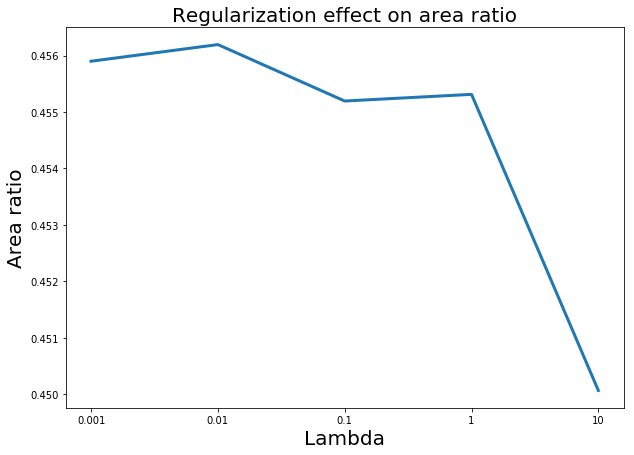

In [5]:
fig, ax = plt.subplots(figsize = (10,7))
plt.plot(np.log10([10**l for l in range(-3,2)]), [i[0] for i in area_ratios],
        linewidth = 3)

plt.title("Regularization effect on area ratio", fontsize = 20)
plt.ylabel("Area ratio", fontsize = 20)
plt.xlabel("Lambda", fontsize = 20)
plt.xticks([i for i in range(-3,2)], [10**l for l in range(-3,2)])
fig.savefig(PATH.joinpath("Regularization effect on area ratio.png"))

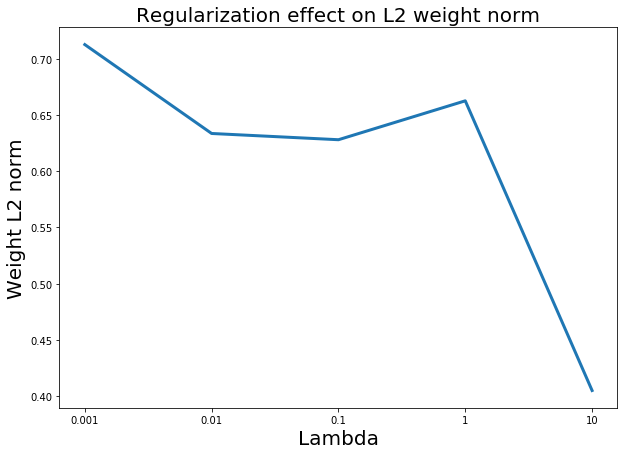

In [6]:
# Checking regularization parameter effect on weight norm
weight_l2 = []
for model in models:
    s = 0
    for layer in model.layers:
        s += np.sum(layer.W**2)
    weight_l2.append(s)

fig, ax = plt.subplots(figsize = (10,7))
plt.plot(np.log10([10**l for l in range(-3,2)]), weight_l2,
        linewidth = 3)
plt.title("Regularization effect on L2 weight norm", fontsize = 20)
plt.ylabel("Weight L2 norm", fontsize = 20)
plt.xlabel("Lambda", fontsize = 20)
plt.xticks([i for i in range(-3,2)], [10**l for l in range(-3,2)])
fig.savefig(PATH.joinpath("Regularization effect on weight norm.png"))

# Learning rate / lambda plot

In [7]:
# Examining learning rate and lambda grid
models = []
p1 = [10**l for l in range(-3,2)] # regularization
p2 = [0.001, 0.01, 0.1] # Learning rate
grid = []
for i in p1:
    for j in p2:
        nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                           [1], 
                           ['sigmoid'], 
                           'logistic')
        nn.train(512, 300, j, i)
        grid.append([i,j])
        models.append(nn)

EPOCH 0 :
logistic cost: 0.7358771823546226
validaltion logistic cost: 0.7300154776450807


EPOCH 30 :
logistic cost: 0.6055119075507206
validaltion logistic cost: 0.602366408790271


EPOCH 60 :
logistic cost: 0.5476495306074807
validaltion logistic cost: 0.5457752880138025


EPOCH 90 :
logistic cost: 0.516343522006342
validaltion logistic cost: 0.5151326262172594


EPOCH 120 :
logistic cost: 0.49811003549833227
validaltion logistic cost: 0.4974974733586307


EPOCH 150 :
logistic cost: 0.4868887546052626
validaltion logistic cost: 0.4868280730741481


EPOCH 180 :
logistic cost: 0.47966021885592613
validaltion logistic cost: 0.48007496989271575


EPOCH 210 :
logistic cost: 0.4748182587352289
validaltion logistic cost: 0.4756280892847353


EPOCH 240 :
logistic cost: 0.4714635156952763
validaltion logistic cost: 0.47259691282145583


EPOCH 270 :
logistic cost: 0.46906992748257215
validaltion logistic cost: 0.47046692303467685


EPOCH 299 :
logistic cost: 0.46736826089456357
validaltion lo

EPOCH 30 :
logistic cost: 0.4597761359889215
validaltion logistic cost: 0.4625059755160681


EPOCH 60 :
logistic cost: 0.4598172501027806
validaltion logistic cost: 0.46246255500936256


EPOCH 90 :
logistic cost: 0.459818772795992
validaltion logistic cost: 0.46244244773033355


EPOCH 120 :
logistic cost: 0.45981289619870397
validaltion logistic cost: 0.46243260367550904


EPOCH 150 :
logistic cost: 0.45980805818788434
validaltion logistic cost: 0.4624275914230287


EPOCH 180 :
logistic cost: 0.45980517657451203
validaltion logistic cost: 0.46242479971325795


EPOCH 210 :
logistic cost: 0.4598038137863985
validaltion logistic cost: 0.4624230841552658


EPOCH 240 :
logistic cost: 0.45980340801443553
validaltion logistic cost: 0.46242193661146014


EPOCH 270 :
logistic cost: 0.45980352796164414
validaltion logistic cost: 0.4624211202205314


EPOCH 299 :
logistic cost: 0.4598038792001559
validaltion logistic cost: 0.4624205337414678


EPOCH 0 :
logistic cost: 0.7746287046167124
validaltio

In [8]:
area_ratios = get_area_ratios(models, X_train, X_test, y_train, y_test)

grid = np.array(grid)
area_ratios = np.array([[i, j] for i, j in area_ratios])
results = np.concatenate((grid, area_ratios), axis = 1)
results = pd.DataFrame(results, columns = ['p1', 'p2', 'test_AR', 'train_AR'])

results.to_csv(PATH.joinpath("3d_plot_data.csv"))

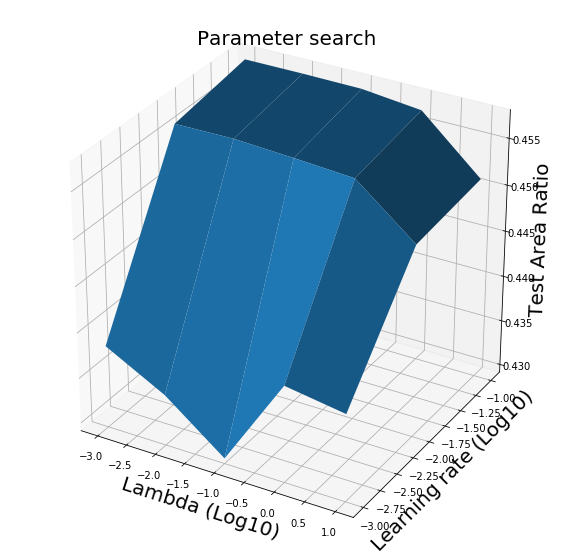

In [9]:
results = pd.read_csv(PATH.joinpath("3d_plot_data.csv"))
plot_3d_results(X = p1, Y = p2, results = results,  
                metric = "test_AR", 
               save_as = "parameter_search_LR")

# Best logisitc regression model

In [10]:
# Locate best parameter setting
results = pd.read_csv(PATH.joinpath("3d_plot_data.csv"))
params = results[results.test_AR == results.test_AR.max()]

nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                       [1], 
                       ['sigmoid'], 
                       'logistic')
nn.train(512, 300, learning_rate = params.p2.values[0], l2_lambda = params.p1.values[0], keep_history = True)

EPOCH 0 :
logistic cost: 0.5052140347767284
validaltion logistic cost: 0.5069068792483036


EPOCH 30 :
logistic cost: 0.4601177857964412
validaltion logistic cost: 0.4625528270142578


EPOCH 60 :
logistic cost: 0.4598980732611646
validaltion logistic cost: 0.46248184553102584


EPOCH 90 :
logistic cost: 0.45981531427950034
validaltion logistic cost: 0.46245688173907307


EPOCH 120 :
logistic cost: 0.4597742814960214
validaltion logistic cost: 0.4624416286371053


EPOCH 150 :
logistic cost: 0.4597551970345871
validaltion logistic cost: 0.46243150631645175


EPOCH 180 :
logistic cost: 0.4597476785977502
validaltion logistic cost: 0.4624244543763016


EPOCH 210 :
logistic cost: 0.4597460110204267
validaltion logistic cost: 0.4624193593906464


EPOCH 240 :
logistic cost: 0.45974710053663365
validaltion logistic cost: 0.4624155809003018


EPOCH 270 :
logistic cost: 0.45974930980806167
validaltion logistic cost: 0.46241272763572555


EPOCH 299 :
logistic cost: 0.45975172048769253
validaltion

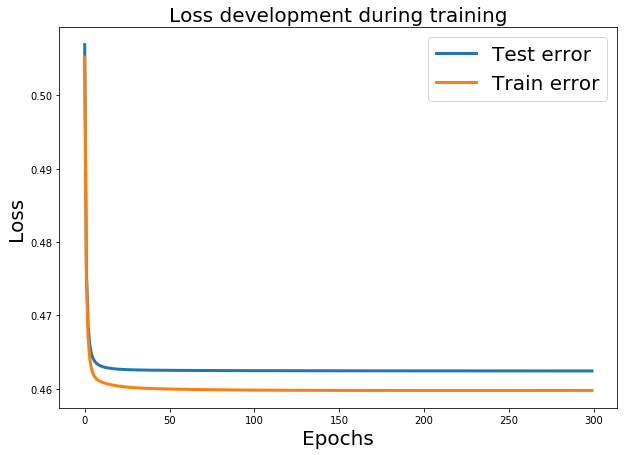

In [11]:
# Examine loss development during training
fig, ax = plt.subplots(figsize = (10,7))
plt.plot([i[0] for i in nn.history], [i[1] for i in nn.history], label = "Test error",linewidth = 3)
plt.plot([i[0] for i in nn.history], [i[2] for i in nn.history], label = "Train error", linewidth = 3)
plt.legend(prop={'size': 20})
plt.title("Loss development during training", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.xlabel("Epochs", fontsize = 20)
fig.savefig(PATH.joinpath("Loss development during training NN.png"))

In [12]:
test_pred = nn.predict(X_test)
train_pred = nn.predict(X_train)

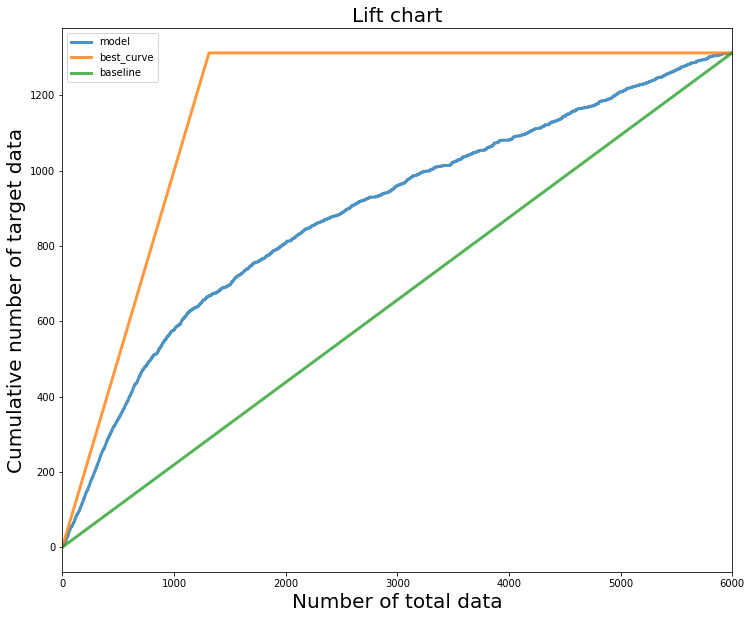

In [13]:
plot_lift(test_pred, y_test, "test")

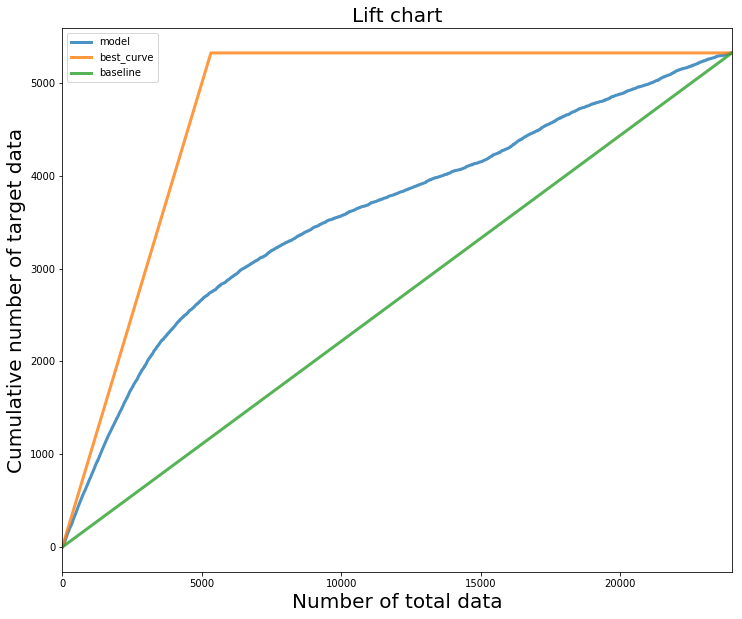

In [14]:
plot_lift(train_pred, y_train, 'train')

In [15]:
result_table_classification(train_pred, y_train, test_pred, y_test).to_csv(PATH.joinpath("logistic_model_score.csv"))